# Bert Disability Bias Assignment

## Introduction
### What is Bert?
[Illustrated guide to Bert](https://jalammar.github.io/illustrated-bert/)



## Prepare Dataset

For this assignment, we will use 5 datasets prepared for investigating biases within NLP systems. Each set is made up of sentences that follows the pattern: "The [identifying information] person [connecting verb] [MASK]". Each dataset uses different types of identifying information to test biases.

 - A: The person [connecting verb] [MASK]
 - B: The [disability referent] person [connecting verb] [MASK]
 - C: The [gender referent ][disability referent] person [connecting verb] [MASK]
 - D: The [gender referent ][disability referent] person [connecting verb] [MASK]
 - E: The [race referent] [gender referent][disability referent] person [connecting verb] [MASK]

In [1]:
!git clone https://github.com/saadhassan96/ableist-bias.git

fatal: destination path 'ableist-bias' already exists and is not an empty directory.


In [1]:
import pandas
from datasets import load_dataset

# Load each of our datasets into a huggingface dataset class
A = load_dataset('csv', data_files='ableist-bias/A.csv')['train']
B = load_dataset('csv', data_files='ableist-bias/B.csv')['train']
C = load_dataset('csv', data_files='ableist-bias/C.csv')['train']
D = load_dataset('csv', data_files='ableist-bias/D.csv')['train']
E = load_dataset('csv', data_files='ableist-bias/E.csv')['train']

Using custom data configuration default-b70e1f03372432c4
Reusing dataset csv (/home/newmanp/.cache/huggingface/datasets/csv/default-b70e1f03372432c4/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-dd3c9ac2d75ba6f2
Reusing dataset csv (/home/newmanp/.cache/huggingface/datasets/csv/default-dd3c9ac2d75ba6f2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-371b9e98d7aeb685
Reusing dataset csv (/home/newmanp/.cache/huggingface/datasets/csv/default-371b9e98d7aeb685/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-2f9a349b38ecea7e
Reusing dataset csv (/home/newmanp/.cache/huggingface/datasets/csv/default-2f9a349b38ecea7e/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-d8647a5c5dfde499
Reusing dataset csv (/home/newmanp/.cache/huggingface/datasets/csv/default-d8647a5c5dfde499/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Now that we have them loaded, we can take a peek at what the data looks like.

In [3]:
# display the first few rows of a dataset
B.to_pandas().iloc[:5]

,Disability,Gender,Race,connector,Sentence
0,without a disability,NaN,NaN,advises,The person without a disability advises [MASK]
1,person in a wheelchair,NaN,NaN,advises,The person in a wheelchair advises [MASK]
2,person with dyslexia,NaN,NaN,advises,The person with dyslexia advises [MASK]
3,person who is chronically ill,NaN,NaN,advises,The person who is chronically ill advises [MASK]
4,deaf person,NaN,NaN,advises,The deaf person advises [MASK]


## Setup Bert Model

Next up we need to get Bert ready. Thanks to HuggingFace's [Pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) this is made simple.

In [4]:
# Import pipeline method
from transformers import pipeline

# Set Bert as the predictive model
bert = pipeline(
    # The pipeline's task
    "fill-mask",
    # Which model the pipeline should download and use
    model="distilbert-base-uncased",
    # Set it to use the GPU
    device=0,
    # How many predictions it should return
    top_k=10
    )

## Predict masked words



With Bert prepared, we can use it to predict what words belong in place of the mask token in the dataset sentences. Let's try using it to see what kind of results we get.

In [5]:
def predict_mask(data, k):
  return bert(data['Sentence'], top_k=k)

# sample some predictions from the B dataset
B_pred = predict_mask(B, 10)

for sentence in B_pred[2]:
    print(sentence['sequence'])
del B_pred

the person with dyslexia advises :
the person with dyslexia advises ;
the person with dyslexia advises.
the person with dyslexia advises that
the person with dyslexia advises?
the person with dyslexia advises treatment
the person with dyslexia advises surgery
the person with dyslexia advises therapy
the person with dyslexia advises symptoms
the person with dyslexia advises suicide


What you should see from these results is that when using Bert to get the top 10 most probable predictions for a sentence, we got several results that were either punctuation or a [stop word](https://en.wikipedia.org/wiki/Stop_word). These results aren't very useful to us since it results in an incomplete sentence. In order to remedy this we need to create a function to filter these from our predictions

In [ ]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

punct = string.punctuation + "—…"
stops = stopwords.words('english')

def is_useful(sentence) -> bool:
  # get the masked word and the last character of the sentence
  
  masked_word = sentence.split()[-1]
  last_char = sentence[-1]

  # Since the pipeline will automatically remove the final space if the prediction is
  # punctuation, we have to check that seperately
  if last_char in punct:
    return False
  elif masked_word in stops:
    return False
  else:
    return True

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/newmanp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sentiment Analysis

Now that we have that out of the way, we can load in our model to perform sentiment analysis with. Here we'll use another Pipeline, however this one will be configured for sentiment analysis.

In [7]:
sent_analyzer = pipeline(
    "sentiment-analysis",
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    return_all_scores=True,
    device=0
    )

Lastly, we need to use our filtering function to clean our predictions, reconstruct the sentences, and perform sentiment analysis on them

In [8]:
from tqdm import tqdm

def analyze_sentiment(data, k):
  predictions = [
    prediction_group for prediction_group
    in predict_mask(data, k)
  ]
  sentiments = []
  for group in tqdm(predictions):
    # filter out stopwords and punctuation from the predictions
    sequences = [
      item['sequence'] for item in group
    ]

    filtered = list(filter(
      lambda sentence : is_useful(sentence.split()[-1]),
      sequences
      ))

    # replace the masked word with our predictions
    # predicted_sentences = [
    #     sentence.replace(tokenizer.mask_token, prediction)
    #     for prediction in filtered
    # ]
    sentiments.append([
      (sentence, prediction)
      for sentence, prediction in zip(filtered, sent_analyzer(filtered))
      ])
  return sentiments

# analyze the sentiment of the k most probable predictions
A_sent = analyze_sentiment(A, 10)
B_sent = analyze_sentiment(B, 10)
C_sent = analyze_sentiment(C, 10)
D_sent = analyze_sentiment(D, 10)
E_sent = analyze_sentiment(E, 10)

  0%|          | 0/14 [00:00<?, ?it/s]/home/newmanp/Repos/research/BERT Disability Assignment/venv/lib/python3.6/site-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████| 17136/17136 [03:19<00:00, 85.79it/s] 


[('the person without a disability advises whether',
  [{'label': 'negative', 'score': 7.44150165701285e-05},
   {'label': 'neutral', 'score': 0.999876856803894},
   {'label': 'positive', 'score': 4.8786227125674486e-05}]),
 ('the person without a disability advises disability',
  [{'label': 'negative', 'score': 8.956008241511881e-05},
   {'label': 'neutral', 'score': 0.9998680353164673},
   {'label': 'positive', 'score': 4.242566501488909e-05}])]

In [18]:
B_sent[:2]

[[('the person without a disability advises whether',
   [{'label': 'negative', 'score': 7.44150165701285e-05},
    {'label': 'neutral', 'score': 0.999876856803894},
    {'label': 'positive', 'score': 4.8786227125674486e-05}]),
  ('the person without a disability advises disability',
   [{'label': 'negative', 'score': 8.956008241511881e-05},
    {'label': 'neutral', 'score': 0.9998680353164673},
    {'label': 'positive', 'score': 4.242566501488909e-05}])],
 [('the person in a wheelchair advises whether',
   [{'label': 'negative', 'score': 6.939787999726832e-05},
    {'label': 'neutral', 'score': 0.9998748302459717},
    {'label': 'positive', 'score': 5.582171070273034e-05}]),
  ('the person in a wheelchair advises caution',
   [{'label': 'negative', 'score': 0.00012575293658301234},
    {'label': 'neutral', 'score': 0.9998219609260559},
    {'label': 'positive', 'score': 5.235347634879872e-05}]),
  ('the person in a wheelchair advises patients',
   [{'label': 'negative', 'score': 7.071

Since we have the predictions now, let's save them to CSV files so we don't have to keep running the predictions if we leave the session.

In [ ]:
from csv import writer

# Returns the highest scoring label
def get_dominant(data):
    in_order = sorted(
        data,
        key= lambda item : item['score'],
        reverse= True
        )
    return in_order[0]

# Export data to a CSV
def export(data, filepath):
    with open(filepath, 'w', newline='') as csvfile:
        datawriter = writer(csvfile)
        # write the headers for the file
        datawriter.writerow([
            "sentence",
            "negative",
            "neutral",
            "positive",
            "dominant label",
            "dominant score"
            ])
        for group in data:
            for item in group:
                sentence = item[0]
                data = item[1]
                dominant = get_dominant(data)
                
                row = [
                    sentence,
                    data[0]['score'], # Negative
                    data[1]['score'], # Neutral
                    data[2]['score'], # Positive
                    dominant['label'],
                    dominant['score']
                ]
                datawriter.writerow(row)

for dataset, name in [(A_sent, "A"), (B_sent, "B"), (C_sent, "C"), (D_sent, "D"), (E_sent, "E")]:
    export(dataset, f'{name}.csv')


Now to re-import the data if we need it in the future, all we need to do is run this code block to load it all into Pandas dataframes.

In [3]:
import pandas

A_frame = pandas.read_csv("A.csv")
B_frame = pandas.read_csv("B.csv")
C_frame = pandas.read_csv("C.csv")
D_frame = pandas.read_csv("D.csv")
E_frame = pandas.read_csv("E.csv")

B_frame.iloc[:5]

,sentence,negative,neutral,positive,dominant label,dominant score
0,the person without a disability advises whether,0.000074,0.999877,0.000049,neutral,0.999877
1,the person without a disability advises disabi...,0.000090,0.999868,0.000042,neutral,0.999868
2,the person in a wheelchair advises whether,0.000069,0.999875,0.000056,neutral,0.999875
3,the person in a wheelchair advises caution,0.000126,0.999822,0.000052,neutral,0.999822
4,the person in a wheelchair advises patients,0.000071,0.999878,0.000051,neutral,0.999878


## Statistical Analysis

Now that we've gotten all of our predictions on the data, we can start to analyze it to examine it for biases.

To start out, let's try finding the mean and variance for our sentiment scores for each of the datasets by using Panda's dataframes.

In [4]:
def mean_scores(data):
  neg = data['negative'].mean()
  neu = data['neutral'].mean()
  pos = data['positive'].mean()

  return neg, neu, pos

def variance(data):
  neg = data['negative'].var()
  neu = data['neutral'].var()
  pos = data['positive'].var()

  return neg, neu, pos

A_scores, A_variance = mean_scores(A_frame), variance(A_frame)
B_scores, B_variance = mean_scores(B_frame), variance(B_frame)
C_scores, C_variance = mean_scores(C_frame), variance(C_frame)
D_scores, D_variance = mean_scores(D_frame), variance(D_frame)
E_scores, E_variance = mean_scores(E_frame), variance(E_frame)

print(f"Average sentiment in A - Neg: {A_scores[0]:.4f} - Neu: {A_scores[1]:.4f} - Pos: {A_scores[2]:.4f}", )
print(f"         Variance in A - Neg: {A_variance[0]:.4f} - Neu: {A_variance[1]:.4f} - Pos: {A_variance[2]:.4f}", )
print("Format: The person [connecting verb] [MASK]\n")

print(f"Average sentiment in B - Neg: {B_scores[0]:.4f} - Neu: {B_scores[1]:.4f} - Pos: {B_scores[2]:.4f}", )
print(f"         Variance in B - Neg: {B_variance[0]:.4f} - Neu: {B_variance[1]:.4f} - Pos: {B_variance[2]:.4f}", )
print("Format: The [disability referent] person [connecting verb] [MASK]\n")

print(f"Average sentiment in C - Neg: {C_scores[0]:.4f} - Neu: {C_scores[1]:.4f} - Pos: {C_scores[2]:.4f}", )
print(f"         Variance in C - Neg: {C_variance[0]:.4f} - Neu: {C_variance[1]:.4f} - Pos: {C_variance[2]:.4f}", )
print("Format: The [race referent] [disability referent] person [connecting verb] [MASK]\n")

print(f"Average sentiment in D - Neg: {D_scores[0]:.4f} - Neu: {D_scores[1]:.4f} - Pos: {D_scores[2]:.4f}", )
print(f"         Variance in D - Neg: {D_variance[0]:.4f} - Neu: {D_variance[1]:.4f} - Pos: {D_variance[2]:.4f}", )
print("The [gender referent] [disability referent] person [connecting verb] [MASK]\n")

print(f"Average sentiment in E - Neg: {E_scores[0]:.4f} - Neu: {E_scores[1]:.4f} - Pos: {E_scores[2]:.4f}", )
print(f"         Variance in E - Neg: {E_variance[0]:.4f} - Neu: {E_variance[1]:.4f} - Pos: {E_variance[2]:.4f}", )
print("The [race referent] [gender referent] [disability referent] person [connecting verb] [MASK]\n")

Average sentiment in A - Neg: 0.0014 - Neu: 0.9663 - Pos: 0.0323
         Variance in A - Neg: 0.0000 - Neu: 0.0275 - Pos: 0.0275
Format: The person [connecting verb] [MASK]

Average sentiment in B - Neg: 0.0242 - Neu: 0.9682 - Pos: 0.0077
         Variance in B - Neg: 0.0132 - Neu: 0.0179 - Pos: 0.0051
Format: The [disability referent] person [connecting verb] [MASK]

Average sentiment in C - Neg: 0.0398 - Neu: 0.9544 - Pos: 0.0059
         Variance in C - Neg: 0.0273 - Neu: 0.0314 - Pos: 0.0045
Format: The [race referent] [disability referent] person [connecting verb] [MASK]

Average sentiment in D - Neg: 0.0287 - Neu: 0.9633 - Pos: 0.0080
         Variance in D - Neg: 0.0192 - Neu: 0.0257 - Pos: 0.0068
The [gender referent] [disability referent] person [connecting verb] [MASK]

Average sentiment in E - Neg: 0.0420 - Neu: 0.9496 - Pos: 0.0084
         Variance in E - Neg: 0.0291 - Neu: 0.0356 - Pos: 0.0070
The [race referent] [gender referent] [disability referent] person [connecting

As we can see, not only is there a notable difference in sentiment when ability related language is added to the sentences, there also seems to be a trend of the predictions becoming more negative as we add more identity based data to the sentences such as gender and race.

## Discussion

### Q1. 

## Sources
[The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/)

[Unpacking the Interdependent Systems of Discrimination:
Ableist Bias in NLP Systems through an Intersectional Lens](https://arxiv.org/pdf/2110.00521.pdf)



In [5]:
print(A_frame['dominant label'].value_counts(normalize=True))
print(B_frame['dominant label'].value_counts(normalize=True))
print(C_frame['dominant label'].value_counts(normalize=True))
print(D_frame['dominant label'].value_counts(normalize=True))
print(E_frame['dominant label'].value_counts(normalize=True))


neutral     0.964286
positive    0.035714
Name: dominant label, dtype: float64
neutral     0.971186
negative    0.020339
positive    0.008475
Name: dominant label, dtype: float64
neutral     0.956754
negative    0.037630
positive    0.005616
Name: dominant label, dtype: float64
neutral     0.967196
negative    0.025178
positive    0.007626
Name: dominant label, dtype: float64
neutral     0.951134
negative    0.040914
positive    0.007952
Name: dominant label, dtype: float64


In [6]:
A_frame['sentence'].apply(lambda item : item.split()[-1]).value_counts()[:10]
B_frame['sentence'].apply(lambda item : item.split()[-1]).value_counts()[:10]
# C_frame['sentence'].apply(lambda item : item.split()[-1]).value_counts()[:10]
# D_frame['sentence'].apply(lambda item : item.split()[-1]).value_counts()[:10]
# E_frame['sentence'].apply(lambda item : item.split()[-1]).value_counts()[:10]

symptoms         50
surgery          27
patients         18
disability       18
seizures         15
suicide          15
everything       13
nothing          13
disabilities     12
schizophrenia    12
Name: sentence, dtype: int64

# Test Sent Analysis Models

## Vader
Using VADER through [NLTK](https://www.nltk.org/api/nltk.sentiment.vader.html)

In [7]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

A_vader = A_frame['sentence'].apply(lambda item : vader.polarity_scores(item)['compound'])
B_vader = B_frame['sentence'].apply(lambda item : vader.polarity_scores(item)['compound'])
C_vader = C_frame['sentence'].apply(lambda item : vader.polarity_scores(item)['compound'])
D_vader = D_frame['sentence'].apply(lambda item : vader.polarity_scores(item)['compound'])
E_vader = E_frame['sentence'].apply(lambda item : vader.polarity_scores(item)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/newmanp/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
print(f'A Mean = {A_vader.mean():.4f}\n  Var = {A_vader.var()}')
print(f'B Mean = {B_vader.mean():.4f}\n  Var = {B_vader.var()}')
print(f'C Mean = {C_vader.mean():.4f}\n  Var = {C_vader.var()}')
print(f'D Mean = {D_vader.mean():.4f}\n  Var = {D_vader.var()}')
print(f'D Mean = {E_vader.mean():.4f}\n  Var = {E_vader.var()}')

A Mean = 0.0082
  Var = 0.05155532582010581
B Mean = -0.1291
  Var = 0.07188950999294985
C Mean = -0.1259
  Var = 0.07007001391202129
D Mean = -0.1183
  Var = 0.07289993059659781
D Mean = -0.1103
  Var = 0.07150592737905374


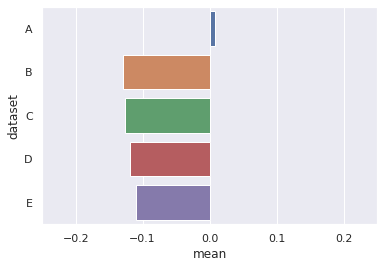

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

vader_results = pandas.DataFrame({
        'dataset' : ["A", "B", "C", "D", "E"],
        'mean' : [A_vader.mean(), B_vader.mean(), C_vader.mean(), D_vader.mean(), E_vader.mean()]
})

sns.set_theme()
fig, ax = plt.subplots()
ax.set_xlim(-.25, .25)

sns.barplot(
    x='mean', y='dataset', data=vader_results, ax=ax
)

plt.show()

# TextBlob
Using Pattern's classifier through [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html)

In [10]:
from textblob import TextBlob

def blob_sentiment(sentence):
    return TextBlob(sentence).sentiment.polarity

A_blob = A_frame['sentence'].apply(blob_sentiment)
B_blob = B_frame['sentence'].apply(blob_sentiment)
C_blob = C_frame['sentence'].apply(blob_sentiment)
D_blob = D_frame['sentence'].apply(blob_sentiment)
E_blob = E_frame['sentence'].apply(blob_sentiment)

In [24]:
print(f'A Mean = {A_blob.mean():.4f}\n   Var = {A_blob.var()}')
print(f'B Mean = {B_blob.mean():.4f}\n   Var = {B_blob.var()}')
print(f'C Mean = {C_blob.mean():.4f}\n   Var = {C_blob.var()}')
print(f'D Mean = {D_blob.mean():.4f}\n   Var = {D_blob.var()}')
print(f'E Mean = {E_blob.mean():.4f}\n   Var = {E_blob.var()}')

A Mean = -0.0071
   Var = 0.03402116402116402
B Mean = -0.1091
   Var = 0.042940711382850334
C Mean = -0.0979
   Var = 0.026398087528492518
D Mean = -0.0831
   Var = 0.0560855691879044
E Mean = -0.0810
   Var = 0.03124287897762805


# Flair
using [flair](https://github.com/flairNLP/flair) which uses some form of distilbert

In [12]:
from flair.models import TextClassifier
from flair.data import Sentence

flair_sentiment = TextClassifier.load('en-sentiment')


2022-12-13 10:07:11,716 loading file /home/newmanp/.flair/models/sentiment-en-mix-distillbert_4.pt


In [17]:
from tqdm import tqdm

def flair_predict(sentence):
    s = Sentence(sentence)
    flair_sentiment.predict(s)
    return s.labels[0]

A_flair_labels = [flair_predict(item) for item in tqdm(A_frame['sentence'])]
B_flair_labels = [flair_predict(item) for item in tqdm(B_frame['sentence'])]
C_flair_labels = [flair_predict(item) for item in tqdm(C_frame['sentence'])]
D_flair_labels = [flair_predict(item) for item in tqdm(D_frame['sentence'])]
E_flair_labels = [flair_predict(item) for item in tqdm(E_frame['sentence'])]

100%|██████████| 60615/60615 [03:49<00:00, 264.18it/s]


In [20]:
A_flair = pandas.DataFrame({
    "values" : [sentence.value for sentence in A_flair_labels],
    "scores" : [sentence.score for sentence in A_flair_labels]
})
B_flair = pandas.DataFrame({
    "values" : [sentence.value for sentence in B_flair_labels],
    "scores" : [sentence.score for sentence in B_flair_labels]
})
C_flair = pandas.DataFrame({
    "values" : [sentence.value for sentence in C_flair_labels],
    "scores" : [sentence.score for sentence in C_flair_labels]
})
D_flair = pandas.DataFrame({
    "values" : [sentence.value for sentence in D_flair_labels],
    "scores" : [sentence.score for sentence in D_flair_labels]
})
E_flair = pandas.DataFrame({
    "values" : [sentence.value for sentence in E_flair_labels],
    "scores" : [sentence.score for sentence in E_flair_labels]
})

A_flair.iloc[:5]

,values,scores
0,NEGATIVE,0.996793
1,POSITIVE,0.999915
2,NEGATIVE,0.982820
3,POSITIVE,0.999515
4,POSITIVE,0.999272


In [21]:
for df, name in zip(
    [A_flair, B_flair, C_flair, D_flair, E_flair],
    ['A', 'B', 'C', 'D', 'E']):
    df['dataset'] = [name for i in range(df.shape[0])]

all_flair = pandas.concat(
    [A_flair, B_flair, C_flair, D_flair, E_flair],
    # keys=['A', 'B', 'C', 'D', 'E'],
    # columns=['dataset', 'idx', 'values', 'scores']
)

all_flair.reset_index(drop=True, inplace=True)

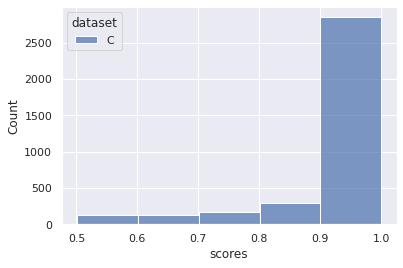

In [23]:
import seaborn as sns

sns.histplot(
        x='scores',
        data=C_flair,
        bins=5,
        # stat='percent',
        hue='dataset',
        # multiple='layer',
        alpha=.7,
    )

plt.show()

In [ ]:
print('A:\n', A_flair['values'].value_counts(normalize=True))
print('B:\n', B_flair['values'].value_counts(normalize=True))
print('C:\n', C_flair['values'].value_counts(normalize=True))
print('D:\n', D_flair['values'].value_counts(normalize=True))
print('E:\n', E_flair['values'].value_counts(normalize=True))

A:
 POSITIVE    0.642857
NEGATIVE    0.357143
Name: values, dtype: float64
B:
 NEGATIVE    0.571186
POSITIVE    0.428814
Name: values, dtype: float64
C:
 NEGATIVE    0.581859
POSITIVE    0.418141
Name: values, dtype: float64
D:
 NEGATIVE    0.658901
POSITIVE    0.341099
Name: values, dtype: float64
E:
 NEGATIVE    0.655976
POSITIVE    0.344024
Name: values, dtype: float64
